# GRAPE calculation of control fields for Bell state plus a noise qubit

This code uses GRAPE to generate control pulses to produce a Bell state in a 2-quibit system will a noise term modeled as an additional qubit coupled to the 2-quibit system of interest (ie, a 3-qubit system).  Allowed control pulses are single-qubit x, y and z operations on the two qubits of interest. This can be viewed as a simplified model system of an electron-nitrogen NV center 2-qubit system (ie, treating the NV electron as a two-state system after zeeman splitting) with a 13C spin-1/2 coupling to the electron spin.

In [193]:
#import packages

%matplotlib inline
import matplotlib.pyplot as plt
import time
import numpy as np
from numpy import pi

from qiskit.visualization import plot_state_city
from qiskit.visualization import plot_bloch_multivector

In [194]:
from qutip import *
qutip.settings.auto_tidyup = False

In [195]:
#set system evolution time and timesteps

T = 4
times = np.linspace(0, T, 200)

In [196]:
#allowed operations in control Hamiltonian. R denotes the number of GRAPE repetitions, higher R will tend to give higher fidelity at the cost of longer computation times.

R = 50
H_ops = [# qubit 1: single-qubit control
         tensor(sigmax(), identity(2), identity(2)),
         tensor(sigmay(), identity(2), identity(2)),
         tensor(sigmaz(), identity(2), identity(2)),
         # qubit 2: single-qubit control
         tensor(identity(2), sigmax(), identity(2)),
         tensor(identity(2), sigmay(), identity(2)),
         tensor(identity(2), sigmaz(), identity(2)),
    
          # # pairwise X-X interactions
             # tensor(sigmax(), sigmax()),
          # # pairwise Y-Y interactions
            # tensor(sigmay(), sigmay()),
          # pairwise Z-Z interactions
          # tensor(sigmaz(), sigmaz(),identity(2)),
         ]

H_labels = [r'$u_{1x}$',
            r'$u_{1y}$',
            r'$u_{1z}$',
            
            r'$u_{2x}$',
            r'$u_{2y}$',
            r'$u_{2z}$',
            
             # r'$u_{xx}$',
             # r'$u_{yy}$',
             #r'$u_{zz}$',
            

            
#             r'$u_{xxi}$',
#             r'$u_{ixx}$',
#             r'$u_{xix}$',
            
#             r'$u_{yyi}$',
#             r'$u_{iyy}$',
#             r'$u_{yiy}$',
            
#             r'$u_{zzi}$',
#             r'$u_{izz}$',
#             r'$u_{ziz}$',
        ]

In [214]:
# Drift Hamiltonian. Includes z precession for each qubit, a coupling between the qubits of interest (1 and 2) and the noise term which couples qubits 1 and 3 (coupling between 2 and 3 is ignored, as dipole-dipole interactions between two nuclear spins is weak).

 
H0 = 0.05 * pi * (tensor(sigmaz(), identity(2), identity(2)) + tensor(identity(2), sigmaz(), identity(2)) + tensor(identity(2), identity(2), sigmaz())) + 0.3*pi*tensor(sigmaz(),sigmaz(),identity(2)) + 0.005*pi*tensor(sigmaz(),identity(2),sigmaz())



H0

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[ 1.42942466  0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          1.08384947  0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.         -0.7696902   0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.         -1.11526539  0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.         -0.80110613  0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.         -1.08384947
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.7696902   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.48694686]]

In [215]:
#target unitary which generates a Bell state of qubits 1 and 2 

U=tensor(cnot(),identity(2))*tensor(hadamard_transform(),identity(2),identity(2))

U

C:\Users\eande\AppData\Local\Temp\ipykernel_25396\331788912.py:3: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  U=tensor(cnot(),identity(2))*tensor(hadamard_transform(),identity(2),identity(2))


Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[ 0.70710678  0.          0.          0.          0.70710678  0.
   0.          0.        ]
 [ 0.          0.70710678  0.          0.          0.          0.70710678
   0.          0.        ]
 [ 0.          0.          0.70710678  0.          0.          0.
   0.70710678  0.        ]
 [ 0.          0.          0.          0.70710678  0.          0.
   0.          0.70710678]
 [ 0.          0.          0.70710678  0.          0.          0.
  -0.70710678  0.        ]
 [ 0.          0.          0.          0.70710678  0.          0.
   0.         -0.70710678]
 [ 0.70710678  0.          0.          0.         -0.70710678  0.
   0.          0.        ]
 [ 0.          0.70710678  0.          0.          0.         -0.70710678
   0.          0.        ]]

# GRAPE

In [216]:
#import GRAPE packages

from qutip.control.grape import cy_grape_unitary, grape_unitary_adaptive, plot_grape_control_fields, _overlap

In [217]:
from scipy.interpolate import interp1d
from qutip.ui.progressbar import TextProgressBar

In [218]:
#starting control Hamiltonian values, initialize randomly

u0 = np.array([np.random.rand(len(times)) * 2 * pi * 0.01 for _ in range(len(H_ops))])

u0 = [np.convolve(np.ones(10)/10, u0[idx,:], mode='same') for idx in range(len(H_ops))]

In [219]:
#GRAPE calculation

result = cy_grape_unitary(U, H0, H_ops, R, times, phase_sensitive=False,
                          u_start=u0, progress_bar=TextProgressBar(),
                          eps=2*pi*5)

10.0%. Run time:  18.94s. Est. time left: 00:00:02:50
20.0%. Run time:  38.24s. Est. time left: 00:00:02:32
30.0%. Run time:  56.40s. Est. time left: 00:00:02:11
40.0%. Run time:  75.43s. Est. time left: 00:00:01:53
50.0%. Run time:  93.18s. Est. time left: 00:00:01:33
60.0%. Run time: 112.50s. Est. time left: 00:00:01:14
70.0%. Run time: 131.07s. Est. time left: 00:00:00:56
80.0%. Run time: 148.93s. Est. time left: 00:00:00:37
90.0%. Run time: 167.06s. Est. time left: 00:00:00:18
Total run time: 184.49s


## Plot control fields for the Bell entangling unitary

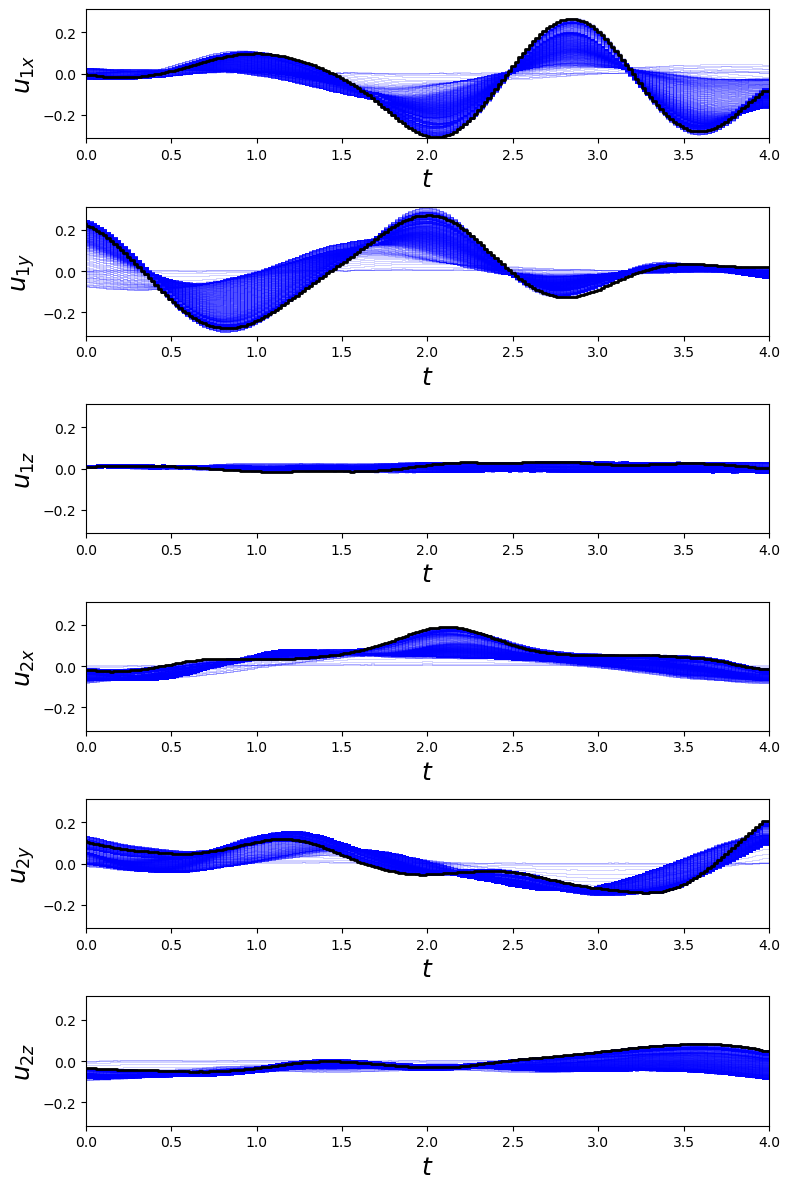

In [203]:
#plot GRAPE control fields

plot_grape_control_fields(times, result.u / (2 * pi), H_labels, uniform_axes=True);

## Fidelity of the resulting GRAPE gate

In [204]:
#print target unitary

U

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[ 0.70710678  0.          0.          0.          0.70710678  0.
   0.          0.        ]
 [ 0.          0.70710678  0.          0.          0.          0.70710678
   0.          0.        ]
 [ 0.          0.          0.70710678  0.          0.          0.
   0.70710678  0.        ]
 [ 0.          0.          0.          0.70710678  0.          0.
   0.          0.70710678]
 [ 0.          0.          0.70710678  0.          0.          0.
  -0.70710678  0.        ]
 [ 0.          0.          0.          0.70710678  0.          0.
   0.         -0.70710678]
 [ 0.70710678  0.          0.          0.         -0.70710678  0.
   0.          0.        ]
 [ 0.          0.70710678  0.          0.          0.         -0.70710678
   0.          0.        ]]

In [205]:
#print GRAPE result

result.U_f.tidyup(1e-1)

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = False
Qobj data =
[[-0.13891276+0.46434076j  0.        +0.j          0.        +0.158282j
   0.        +0.j         -0.15161573+0.82468613j  0.        +0.j
   0.        -0.18802378j  0.        +0.j        ]
 [ 0.        +0.j         -0.52206819+0.j          0.        +0.j
  -0.23834424+0.j          0.        +0.j         -0.76520245+0.j
   0.        +0.j          0.26779392+0.j        ]
 [ 0.        +0.22350256j  0.        +0.j         -0.15530566+0.8125567j
   0.        +0.j          0.        -0.17081997j  0.        +0.j
   0.        +0.48109791j  0.        +0.j        ]
 [ 0.        +0.j         -0.31460837+0.j          0.        +0.j
  -0.74281215+0.j          0.        +0.j          0.24627466+0.j
   0.        +0.j         -0.52215306+0.j        ]
 [ 0.        -0.15133767j  0.        +0.j          0.        +0.48195713j
   0.        +0.j          0.        -0.19039587j  0.        +0.j
   0.1307672

In [206]:
#normalize

result.U_f / result.U_f[0,0] #.tidyup(1e-1)

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = False
Qobj data =
[[ 1.        +0.j          0.        +0.j          0.31287329-0.09359956j
   0.        +0.j          1.71980033-0.18797936j  0.        +0.j
  -0.37166337+0.11118728j  0.        +0.j        ]
 [ 0.        +0.j          0.30872339+1.0319632j   0.        +0.j
   0.14094412+0.47113095j  0.        +0.j          0.45250007+1.5125625j
   0.        +0.j         -0.1583591 -0.52934363j]
 [ 0.44179365-0.13216753j  0.        +0.j          1.69800633-0.17351283j
   0.        +0.j         -0.33765688+0.10101385j  0.        +0.j
   0.95097795-0.28449574j  0.        +0.j        ]
 [ 0.        +0.j          0.18604267+0.62188094j  0.        +0.j
   0.43925963+1.46830396j  0.        +0.j         -0.14563375-0.48680687j
   0.        +0.j          0.30877358+1.03213096j]
 [-0.29914656+0.08949306j  0.        +0.j          0.95267636-0.28500384j
   0.        +0.j         -0.37635223+0.11259j     0.       

In [207]:
#overlap between target and calculated unitaries

abs(_overlap(U, result.U_f))**2

0.4975531914054647

## Cityscape plot of the ideal and GRAPE gates for Bell state with noise qubit


In [208]:
#specify initial state to apply calculated unitary to to generate Bell state

initialstate=tensor(basis(2, 0), basis(2, 0),basis(2, 0)) #initial state
initialstate


Quantum object: dims = [[2, 2, 2], [1, 1, 1]], shape = (8, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]

In [209]:
#Generate ideal and calculated final states

idealfinalstate=U*initialstate
finalstate=result.U_f*initialstate


In [210]:
#generate density matrices

idealdensitymatrix=(idealfinalstate * idealfinalstate.dag())#ideal density matrix
densitymatrix=(finalstate * finalstate.dag())# real density matrix
print (idealdensitymatrix)
print (densitymatrix)

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[0.5 0.  0.  0.  0.  0.  0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.5 0.  0.  0.  0.  0.  0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]]
Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[ 0.2349091 +0.j          0.        +0.j          0.10378135+0.03104736j
   0.        +0.j         -0.07027225-0.02102273j  0.        +0.j
   0.38426666+0.11495769j  0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j        ]
 [ 0.10378135-0.03104736j  0.        +0.j          0.04995339+0.j
   0.        +0.j         -0.03382436+0.j          0.        +0.j
   0.1849

In [211]:
#printing fidelity
fidelity(idealdensitymatrix,densitymatrix)

0.9187727255574772

[[ 0.2349091 +0.j          0.        +0.j          0.10378135+0.03104736j
   0.        +0.j         -0.07027225-0.02102273j  0.        +0.j
   0.38426666+0.11495769j  0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j        ]
 [ 0.10378135-0.03104736j  0.        +0.j          0.04995339+0.j
   0.        +0.j         -0.03382436+0.j          0.        +0.j
   0.18496024+0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j        ]
 [-0.07027225+0.02102273j  0.        +0.j         -0.03382436+0.j
   0.        +0.j          0.02290309+0.j          0.        +0.j
  -0.12523996+0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.      

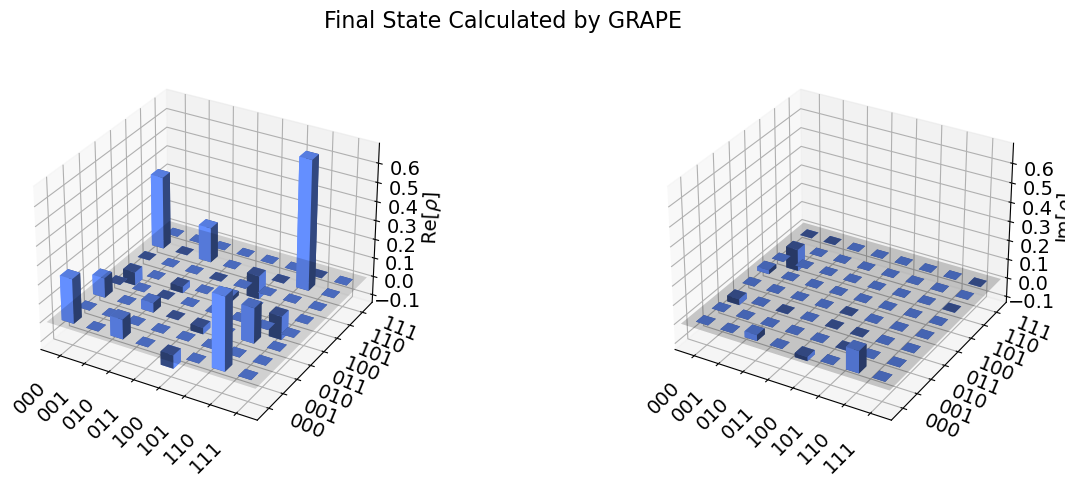

In [212]:
#plotting cityscape for real density matrix
dm=np.array(densitymatrix)
print (dm)
plot_state_city(dm, title='Final State Calculated by GRAPE')

[[0.5+0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0.5+0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0.5+0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0.5+0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j]]


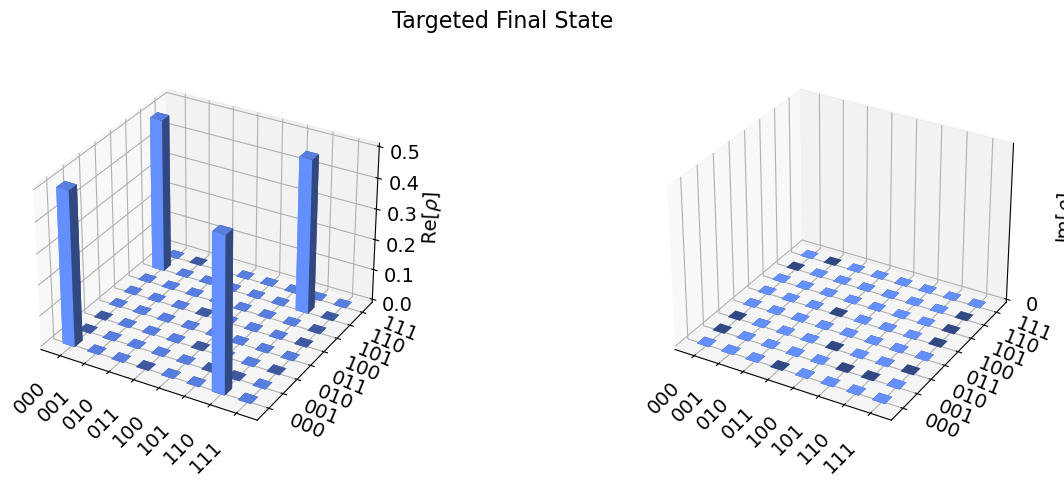

In [213]:
#plotting cityscape for ideal density matrix
idm=np.array(idealdensitymatrix)
print (idm)
plot_state_city(idm, title='Targeted Final State')

## Versions

In [42]:
from qutip.ipynbtools import version_table

version_table()